<a href="https://colab.research.google.com/github/ShengpeiWang/kickstarter/blob/master/kick.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# local colab set up
# remember to turn the GPU option on
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/kick'

Mounted at /content/gdrive


In [0]:
# set up python environment
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.text import *

from sklearn.model_selection import train_test_split

# Load and wrangle the Kickstarter data


In [0]:
# load the kickstarter dataset
# Data cleaning was done in the other jupyter notebooks
with open(base_dir + "/project_data_complete.pkl", "rb") as f:
  df = pickle.load(f)

In [0]:
df['story_tb'] = df["project_name"].map(str) + df["blurb"].map(str) +df["story"].map(str)

In [0]:
df.columns

Index(['index', 'project_id', 'url', 'story', 'project_id', 'project_name',
       'blurb', 'goal', 'pledge', 'state', 'country', 'deadline', 'create',
       'launch', 'staff_pick', 'backers', 'usd_rate', 'creator', 'category',
       'url', 'category_name', 'category_parent', 'name_parent', 'goal_usd',
       'pledge_usd', 'percent', 'days_active', 'days_draft', 'language',
       'keep_story', 'story_tb'],
      dtype='object')

In [0]:
df['l_goal'] = np.log10(df['goal_usd'] + 1)
df['l_pledge'] = np.log10(df['pledge_usd'] + 1)
df['l_percent'] = np.log10(df['percent']*100+1)
max_bin = max(df['percent']*100)+1
df['performance'] = pd.cut(df['percent']*100,
                                 bins = [0, 1, 100, 120, max_bin], 
                                 labels = ["fail", "some", "goal", "great"],
                                 right = False)
df['performance_n'] = pd.cut(df['percent']*100,
                                 bins = [0, 1, 100, 120, max_bin], 
                                 labels = [0,1,2,3],
                                 right = False)

In [0]:
data_y = df[['l_pledge']]
data_x = df[['name_parent', 'l_pledge', 'performance', 'story_tb']]

X_train, X_test, Y_train, _ = train_test_split(data_x, data_y, test_size = 0.20, random_state = 61, stratify = data_x[['name_parent']])

x_train, x_val, _, _ = train_test_split(X_train, Y_train, test_size = 0.20, random_state = 59, stratify = X_train[['name_parent']])

# Preparing the data for fast.ai applications


In [0]:
data_lm = TextLMDataBunch.from_df(path = base_dir, train_df= x_train, valid_df= x_val, text_cols= "story_tb")
# this takes a few seconds to run

In [0]:
data_lm.save('data_lm.pkl')

In [0]:
bs=32

In [0]:
data_lm = load_data(path = base_dir, file = "data_lm.pkl", bs = bs)

In [0]:
# let's take a look at the tokenized text
data_lm.show_batch()

idx,text
0,"- throwing locations in or near baltimore , philadelphia , chicago , san xxunk , detroit , austin , charlotte , denver , and brooklyn , among other xxunk i heard of this sport i quickly jumped online to find a location near me where i could try this out . living in seattle , with its rich logging history , i was shocked to find i would either need"
1,"a great story behind it . the story of luma smartlamp involves great designers like ryan xxunk , tanner slade , drew smith , bryce xxunk , jonny wilson and carter xxunk who were key in defining the silhouette , shaping the functionality and building our successful prototypes.the founding partners of luma smartlamp are brennan xxunk , wes xxunk and dan barnes . these three are also founding partners of"
2,you are very welcome to make a further donation if you wish to support my humble project ! please suggest rewards that you would like to receive as i am out of ideas for that ... do watch the video for a reading of some of my poems ! xxbos xxmaj special xxmaj needs xxmaj self xxmaj sustainable / xxmaj organic xxunk me spread the love ! xxmaj lets start
3,"profitable within 12 months so we can start xxunk hoping to have beta up by march 2016 . this would give us around 3 months to develop this new text to speech technology . xxbos xxmaj two new jazz / fusion albums from xxmaj benjamin xxunk the release of my debut 2019 album , producing my next independent release has resulted in the creation of two new xxunk releasing two"
4,"a modular smartphone gimbal for life . more than a one - trick balance stick . "" stuff xxunk the smartphone puts a camera into a pocket , then this turns it into a mobile studio . "" xxunk more grain in low light ! the integrated usb light has 5 adjustable power settings with colour temperature control . unlike the fixed position light on your smartphone our flexi -"


# Training the language model

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [0]:
learn.lr_find()
# this takes a while

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


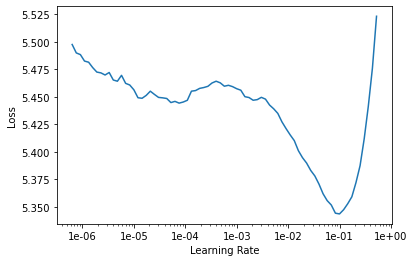

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
# fit one cycle for the last layer
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))
# 

epoch,train_loss,valid_loss,accuracy,time
0,5.025197,4.545310,0.226865,01:17


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (1348 items)
x: LMTextList
xxbos xxmaj gone xxmaj west xxmaj axe xxunk xxmaj west will be xxmaj seattle 's first axe throwing xxunk axe throwing to the pacific xxunk throwing is one of the fastest growing sports in north america . the idea of a commercial location that provided patrons with a safe controlled environment to enjoy the sport originated in canada but has quickly spread throughout the united states . there are axe - throwing locations in or near baltimore , philadelphia , chicago , san xxunk , detroit , austin , charlotte , denver , and brooklyn , among other xxunk i heard of this sport i quickly jumped online to find a location near me where i could try this out . living in seattle , with its rich logging history , i was shocked to find i would either need to leave the country , or drive nearly 800 miles to the closest location in the united xxunk was then i started looking into the logistics of opening a location in 

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))
# takes about 1.5 min per epoch in colab
# five cycle is more than enough for the validation loss to go up again
# only need two cycles really

epoch,train_loss,valid_loss,accuracy,time
0,4.332877,4.455299,0.234397,01:21
1,4.184784,4.409348,0.238235,01:23
2,3.961340,4.393872,0.240643,01:23
3,3.709462,4.408422,0.240292,01:23
4,3.536141,4.427670,0.238813,01:23


In [0]:
learn.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.357017,4.426204,0.237837,01:23
1,4.098324,4.397897,0.240432,01:23


In [0]:
learn.save('fine_tuned')

In [0]:
# test if model makes sense:
TEXT = "FALSOBORDONE is one of Sweden's foremost medieval ensembles"
N_WORDS = 40
N_SENTENCES = 2

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))
# this makes some sense

FALSOBORDONE is one of Sweden's foremost medieval ensembles , with a deep love for Sweden . It is the world layer of the world . in our contemporary era , it is the only place you need to be there . it was one of the
FALSOBORDONE is one of Sweden's foremost medieval ensembles . We are working with creating the best way to feel an amazing project . we are working on producing a series of original songs from vienna to somewhere else . we have been working on a studio and


In [0]:
# save the encoder
learn.save_encoder('fine_tuned_enc')

# Train classifier

In [0]:
data = TextDataBunch.from_df(path = base_dir, train_df= x_train, valid_df= x_val, test_df = X_test, 
                                text_cols= "story_tb", label_cols= 'l_pledge', vocab=data_lm.vocab)

In [0]:
data.save('data.pkl')

In [0]:
bs = 16
data = load_data(path = base_dir, file = "data.pkl", bs = bs)

In [0]:
data.show_batch()

text,target
"xxbos xxmaj fantasy xxmaj novel : xxmaj age of xxmaj death by xxmaj michael xxup j. xxunk 5th book in the xxmaj legends of the xxmaj first xxmaj empire xxmaj series by the xxmaj new xxmaj york xxmaj times , xxup usa xxmaj today , and xxmaj washington xxmaj post xxmaj bestselling xxmaj xxunk all are the best , most supportive , and all around greatest people there are .",5.076779
"xxbos xxup us xxup open xxmaj swing xxmaj dance xxmaj championship 2017 - xxup tv xxunk are taping the 2017 xxup us xxmaj open xxmaj swing xxmaj dance xxmaj championships , xxmaj inc , competition for a one hour cable ready xxup tv show , for broadcast in 2018 . we are excited to share some exciting swing news . your passion for dance and specifically swing ( i.e. west",3.350442
xxbos xxmaj jaxon xxmaj stewart & xxmaj the xxmaj dragon xxunk you been looking for a brand new xxmaj young xxmaj adult series that is similar to xxmaj harry xxmaj potter ? xxmaj then xxmaj jaxon xxmaj stewart is the book series for xxunk you been looking for a brand new young adult series that is similar to harry potter ? then jaxon stewart is the book series for you,1.8570695
"xxbos bikers : xxmaj bicycle xxmaj kinetic xxmaj energy xxmaj recovery xxunk kinetic energy recovery system for bicycles , which can provide assistance to riders by harvesting energy during low - impact xxunk is the aim of this xxunk design and build a prototype kinetic energy recovery system ( kers ) for a bicycle that can provide xxunk assistance to riders , which requires no pre - charging and is",1.6940072
"xxbos xxmaj project xxmaj hemp . xxup uk legal xxmaj hemp / xxmaj cannabis xxmaj crowdfunding xxmaj site . xxmaj crowdfunding site with a specialty in cannabis & hemp . xxmaj crowdfunding for legal cannabis businesses as well as activism xxunk hemp aims to be the first crowdfunding platform in the uk to specialise solely on the cannabis marketplace , and activism scene . this will be for businesses ,",1.2464902


In [6]:
learn_cl = text_classifier_learner(data, AWD_LSTM, drop_mult=0.5)
learn_cl.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1348 items)
x: TextList
xxbos xxmaj gone xxmaj west xxmaj axe xxunk xxmaj west will be xxmaj seattle 's first axe throwing xxunk axe throwing to the pacific xxunk throwing is one of the fastest growing sports in north america . the idea of a commercial location that provided patrons with a safe controlled environment to enjoy the sport originated in canada but has quickly spread throughout the united states . there are axe - throwing locations in or near baltimore , philadelphia , chicago , san xxunk , detroit , austin , charlotte , denver , and brooklyn , among other xxunk i heard of this sport i quickly jumped online to find a location near me where i could try this out . living in seattle , with its rich logging history , i was shocked to find i would either need to leave the country , or drive nearly 800 miles to the closest location in the united xxunk was then i started looking into the logistics of opening a location in the s

In [7]:
learn_cl.lr_find()

epoch,train_loss,valid_loss,time
0,8.312231,#na#,02:49


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


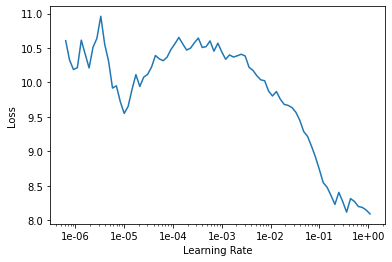

In [9]:
learn_cl.recorder.plot()

In [10]:
learn_cl.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,3.360734,1.721754,02:51


In [0]:
learn_cl.save('first')

In [12]:
learn_cl.freeze_to(-2)
learn_cl.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,1.907608,1.654298,03:05


In [0]:
learn_cl.save('second')

In [16]:
learn_cl.freeze_to(-3)
learn_cl.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,1.582841,1.336562,02:44


In [0]:
learn_cl.save('third')

In [18]:
learn_cl.unfreeze()
learn_cl.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,1.250114,1.173103,03:15
1,1.174074,1.191620,03:02


In [19]:
learn_cl.predict("I really loved that movie, it was awesome!")
# yeah a one liner will not get much pledged.

(FloatItem [0.88768], tensor([0.8877]), tensor([0.8877]))